# Event Study Analysis: Regression-Based Approach
## Using Controls from 2SLS Analysis to Isolate Event Effects (Two Events)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/processed/daily_regression_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

print(f"Data range: {df['date'].min()} to {df['date'].max()}")
print(f"Total observations: {len(df)}")

## Define Events and Create Event Dummies

We'll create:
- **Event window dummies** (7 days before/after)
- **Post-event dummies** (8-30 days after)

In [ ]:
# Define events
events = {
    'nethermind': '2024-01-21',
    'shanghai': '2023-04-12'
}

# Create event dummies
for event_name, event_date in events.items():
    event_date = pd.to_datetime(event_date)
    df[f'{event_name}_event'] = ((df['date'] >= event_date) & 
                                  (df['date'] <= event_date + pd.Timedelta(days=7))).astype(int)
    df[f'{event_name}_post'] = ((df['date'] > event_date + pd.Timedelta(days=7)) & 
                                 (df['date'] <= event_date + pd.Timedelta(days=30))).astype(int)

# Check event dummy distributions
print("\nEvent dummy distributions:")
for event_name in events.keys():
    n_event = df[f'{event_name}_event'].sum()
    n_post = df[f'{event_name}_post'].sum()
    print(f"{event_name.capitalize()}: {n_event} days in event window, {n_post} days in post-event window")

## Regression Model 1: Effect of Events on Centrality

**Model**: 
```
Centrality_t = α + β₁·Event_Window_t + β₂·Post_Event_t + β₃·market_return_t + β₄·eth_return_t + β₅·eth_turnover_t + ε_t
```

This isolates the event effect while controlling for market conditions (same controls as 2SLS).

In [ ]:
def run_event_regression(df, outcome_var, event_name, controls=['market_return', 'eth_return', 'eth_turnover']):
    """Run regression with event dummies and controls"""
    
    # Prepare variables
    event_cols = [f'{event_name}_event', f'{event_name}_post'] + controls
    reg_data = df[['date', outcome_var] + event_cols].dropna()
    
    # Run regression
    y = reg_data[outcome_var]
    X = add_constant(reg_data[event_cols])
    model = OLS(y, X).fit(cov_type='HC3')
    
    return model, reg_data

# Run regressions for each event on top20_mean
print("\n" + "="*80)
print("REGRESSION ANALYSIS: Effect of Events on Top20 Mean Centrality")
print("="*80)

centrality_results = {}
for event_name, event_date in events.items():
    model, reg_data = run_event_regression(df, 'top20_mean', event_name)
    centrality_results[event_name] = model
    
    print(f"\n{event_name.upper()} EVENT ({event_date}):")
    print("-" * 80)
    print(f"Sample size: {len(reg_data)} observations\n")
    
    # Extract key coefficients
    event_coef = model.params[f'{event_name}_event']
    event_se = model.bse[f'{event_name}_event']
    event_pval = model.pvalues[f'{event_name}_event']
    
    post_coef = model.params[f'{event_name}_post']
    post_se = model.bse[f'{event_name}_post']
    post_pval = model.pvalues[f'{event_name}_post']
    
    baseline = model.params['const']
    
    print(f"Baseline centrality (const):        {baseline:>8.4f}")
    print(f"Event window effect (0-7 days):     {event_coef:>8.4f} (SE={event_se:.4f}, p={event_pval:.4f})")
    print(f"Post-event effect (8-30 days):      {post_coef:>8.4f} (SE={post_se:.4f}, p={post_pval:.4f})")
    print(f"\nPercentage changes:")
    print(f"  Event window:  {(event_coef/baseline)*100:+.2f}%")
    print(f"  Post-event:    {(post_coef/baseline)*100:+.2f}%")
    print(f"\nR-squared: {model.rsquared:.4f}")


REGRESSION ANALYSIS: Effect of Events on Top20 Mean Centrality

NETHERMIND EVENT (2024-01-21):
--------------------------------------------------------------------------------
Sample size: 1565 observations

Baseline centrality (const):          4.5568
Event window effect (0-7 days):       0.0779 (SE=0.0109, p=0.0000)
Post-event effect (8-30 days):        0.0136 (SE=0.0169, p=0.4206)

Percentage changes:
  Event window:  +1.71%
  Post-event:    +0.30%

R-squared: 0.0810

SEC EVENT (2023-06-06):
--------------------------------------------------------------------------------
Sample size: 1565 observations

Baseline centrality (const):          4.5732
Event window effect (0-7 days):      -0.3402 (SE=0.0146, p=0.0000)
Post-event effect (8-30 days):       -0.3691 (SE=0.0204, p=0.0000)

Percentage changes:
  Event window:  -7.44%
  Post-event:    -8.07%

R-squared: 0.1546

SHANGHAI EVENT (2023-04-12):
--------------------------------------------------------------------------------
Sample s

## Regression Model 2: Effect of Events on Volatility

**Model**: 
```
Volatility_t = α + β₁·Event_Window_t + β₂·Post_Event_t + β₃·market_return_t + β₄·eth_return_t + β₅·eth_turnover_t + ε_t
```

In [ ]:
print("\n" + "="*80)
print("REGRESSION ANALYSIS: Effect of Events on Volatility")
print("="*80)

volatility_results = {}
for event_name, event_date in events.items():
    model, reg_data = run_event_regression(df, 'prof_garman_klass_vol', event_name)
    volatility_results[event_name] = model
    
    print(f"\n{event_name.upper()} EVENT ({event_date}):")
    print("-" * 80)
    print(f"Sample size: {len(reg_data)} observations\n")
    
    # Extract key coefficients
    event_coef = model.params[f'{event_name}_event']
    event_se = model.bse[f'{event_name}_event']
    event_pval = model.pvalues[f'{event_name}_event']
    
    post_coef = model.params[f'{event_name}_post']
    post_se = model.bse[f'{event_name}_post']
    post_pval = model.pvalues[f'{event_name}_post']
    
    baseline = model.params['const']
    
    print(f"Baseline volatility (const):         {baseline:>8.4f}")
    print(f"Event window effect (0-7 days):      {event_coef:>8.4f} (SE={event_se:.4f}, p={event_pval:.4f})")
    print(f"Post-event effect (8-30 days):       {post_coef:>8.4f} (SE={post_se:.4f}, p={post_pval:.4f})")
    print(f"\nPercentage changes:")
    print(f"  Event window:  {(event_coef/baseline)*100:+.2f}%")
    print(f"  Post-event:    {(post_coef/baseline)*100:+.2f}%")
    print(f"\nR-squared: {model.rsquared:.4f}")


REGRESSION ANALYSIS: Effect of Events on Volatility

NETHERMIND EVENT (2024-01-21):
--------------------------------------------------------------------------------
Sample size: 1565 observations

Baseline volatility (const):           0.0043
Event window effect (0-7 days):        0.0023 (SE=0.0034, p=0.5056)
Post-event effect (8-30 days):        -0.0009 (SE=0.0012, p=0.4549)

Percentage changes:
  Event window:  +53.29%
  Post-event:    -21.29%

R-squared: 0.6257

SEC EVENT (2023-06-06):
--------------------------------------------------------------------------------
Sample size: 1565 observations

Baseline volatility (const):           0.0043
Event window effect (0-7 days):       -0.0013 (SE=0.0020, p=0.5224)
Post-event effect (8-30 days):         0.0008 (SE=0.0012, p=0.4999)

Percentage changes:
  Event window:  -30.24%
  Post-event:    +19.12%

R-squared: 0.6256

SHANGHAI EVENT (2023-04-12):
--------------------------------------------------------------------------------
Sample si

## Regression Model 3: Combined Event-Centrality-Volatility Model

**Key Test**: Does the event affect volatility THROUGH centrality?

**Model**: 
```
Volatility_t = α + β₁·Event_t + β₂·Centrality_t + β₃·Controls_t + ε_t
```

If event coefficients become insignificant after adding centrality, it suggests the event works THROUGH centrality.

In [ ]:
print("\n" + "="*80)
print("MEDIATION ANALYSIS: Do Events Affect Volatility Through Centrality?")
print("="*80)

for event_name, event_date in events.items():
    print(f"\n{event_name.upper()} EVENT ({event_date}):")
    print("-" * 80)
    
    # Model A: Event → Volatility (without centrality)
    event_cols_A = [f'{event_name}_event', f'{event_name}_post', 'market_return', 'eth_return', 'eth_turnover']
    data_A = df[['prof_garman_klass_vol'] + event_cols_A].dropna()
    y_A = data_A['prof_garman_klass_vol']
    X_A = add_constant(data_A[event_cols_A])
    model_A = OLS(y_A, X_A).fit(cov_type='HC3')
    
    # Model B: Event → Volatility (with centrality)
    event_cols_B = event_cols_A + ['top20_mean']
    data_B = df[['prof_garman_klass_vol'] + event_cols_B].dropna()
    y_B = data_B['prof_garman_klass_vol']
    X_B = add_constant(data_B[event_cols_B])
    model_B = OLS(y_B, X_B).fit(cov_type='HC3')
    
    # Compare coefficients
    event_coef_A = model_A.params[f'{event_name}_event']
    event_pval_A = model_A.pvalues[f'{event_name}_event']
    
    event_coef_B = model_B.params[f'{event_name}_event']
    event_pval_B = model_B.pvalues[f'{event_name}_event']
    
    centrality_coef = model_B.params['top20_mean']
    centrality_pval = model_B.pvalues['top20_mean']
    
    print(f"\nModel A (without centrality):")
    print(f"  Event effect on volatility: {event_coef_A:>8.5f} (p={event_pval_A:.4f})")
    print(f"  R-squared: {model_A.rsquared:.4f}")
    
    print(f"\nModel B (with centrality):")
    print(f"  Event effect on volatility: {event_coef_B:>8.5f} (p={event_pval_B:.4f})")
    print(f"  Centrality effect:          {centrality_coef:>8.5f} (p={centrality_pval:.4f})")
    print(f"  R-squared: {model_B.rsquared:.4f}")
    
    # Calculate attenuation
    attenuation = ((event_coef_A - event_coef_B) / event_coef_A * 100) if event_coef_A != 0 else 0
    print(f"\nAttenuation of event effect: {attenuation:.1f}%")
    
    if abs(attenuation) > 30 and centrality_pval < 0.10:
        print("→ EVIDENCE: Event works partially through centrality")
    elif centrality_pval < 0.10:
        print("→ Centrality matters, but event has independent effect")
    else:
        print("→ No clear mediation through centrality")


MEDIATION ANALYSIS: Do Events Affect Volatility Through Centrality?

NETHERMIND EVENT (2024-01-21):
--------------------------------------------------------------------------------

Model A (without centrality):
  Event effect on volatility:  0.00229 (p=0.5056)
  R-squared: 0.6257

Model B (with centrality):
  Event effect on volatility:  0.00191 (p=0.5829)
  Centrality effect:           0.00488 (p=0.0105)
  R-squared: 0.6271

Attenuation of event effect: 16.6%
→ Centrality matters, but event has independent effect

SEC EVENT (2023-06-06):
--------------------------------------------------------------------------------

Model A (without centrality):
  Event effect on volatility: -0.00130 (p=0.5224)
  R-squared: 0.6256

Model B (with centrality):
  Event effect on volatility:  0.00054 (p=0.7880)
  Centrality effect:           0.00540 (p=0.0057)
  R-squared: 0.6272

Attenuation of event effect: 141.7%
→ EVIDENCE: Event works partially through centrality

SHANGHAI EVENT (2023-04-12):
---

## Visualization: Event Effects Over Time

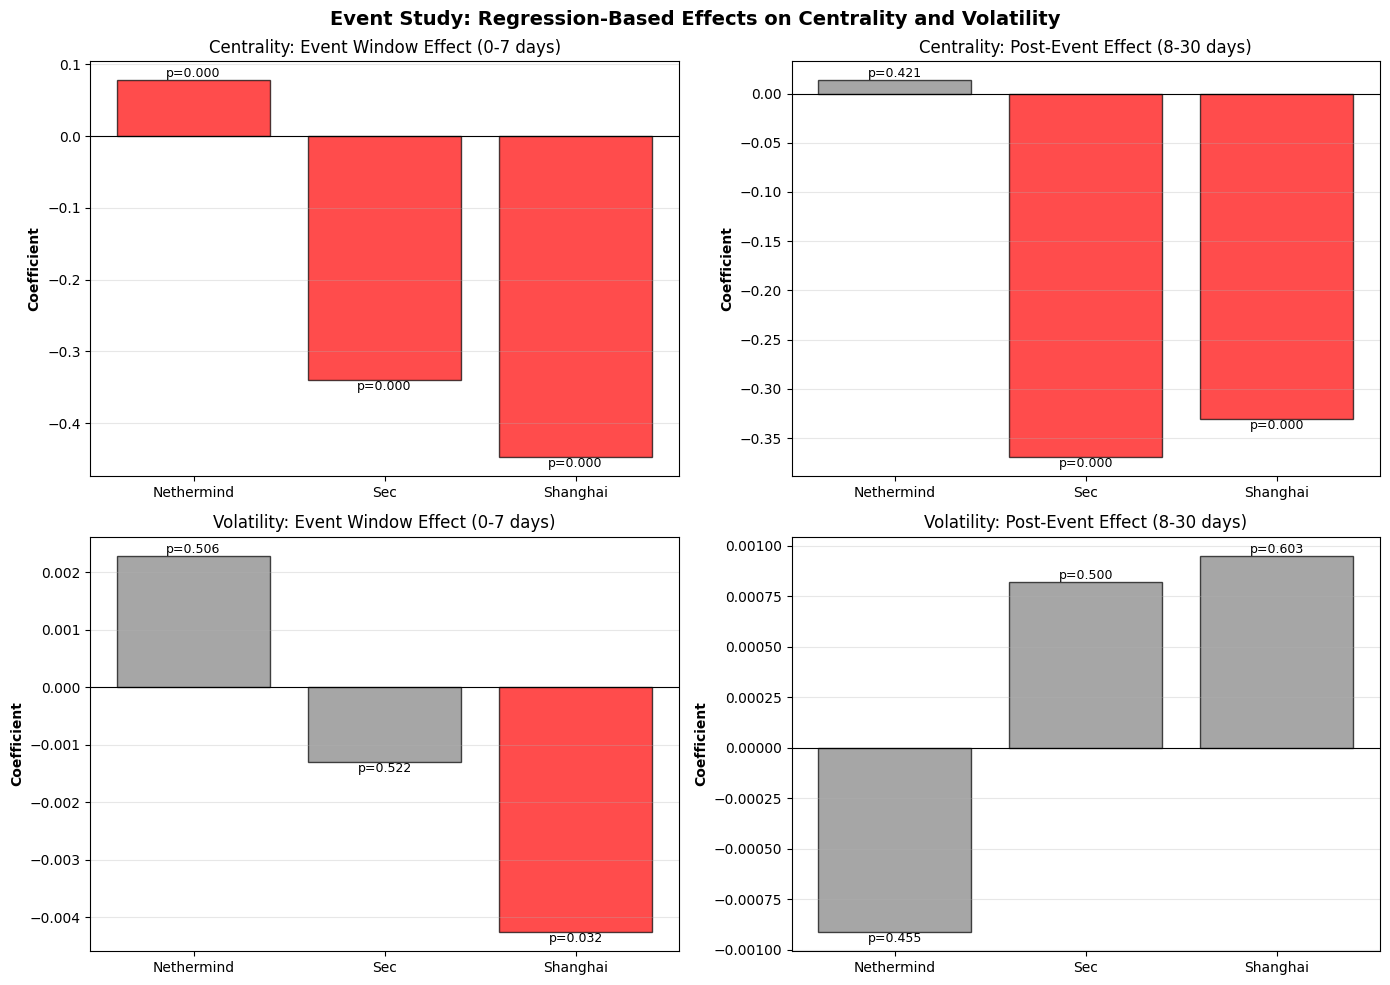


Legend: Red = p<0.05, Orange = p<0.10, Gray = p≥0.10


In [ ]:
# Create summary dataframe
summary_data = []

for event_name in events.keys():
    cent_model = centrality_results[event_name]
    vol_model = volatility_results[event_name]
    
    summary_data.append({
        'Event': event_name.capitalize(),
        'Cent_Event_Coef': cent_model.params[f'{event_name}_event'],
        'Cent_Event_p': cent_model.pvalues[f'{event_name}_event'],
        'Cent_Post_Coef': cent_model.params[f'{event_name}_post'],
        'Cent_Post_p': cent_model.pvalues[f'{event_name}_post'],
        'Vol_Event_Coef': vol_model.params[f'{event_name}_event'],
        'Vol_Event_p': vol_model.pvalues[f'{event_name}_event'],
        'Vol_Post_Coef': vol_model.params[f'{event_name}_post'],
        'Vol_Post_p': vol_model.pvalues[f'{event_name}_post']
    })

summary_df = pd.DataFrame(summary_data)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Event Study: Regression-Based Effects on Centrality and Volatility', 
             fontsize=14, fontweight='bold')

# Plot 1: Centrality - Event Window
ax = axes[0, 0]
colors = ['red' if p < 0.05 else 'orange' if p < 0.10 else 'gray' 
          for p in summary_df['Cent_Event_p']]
bars = ax.bar(summary_df['Event'], summary_df['Cent_Event_Coef'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient', fontweight='bold')
ax.set_title('Centrality: Event Window Effect (0-7 days)')
ax.grid(True, alpha=0.3, axis='y')
for bar, p_val in zip(bars, summary_df['Cent_Event_p']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'p={p_val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Plot 2: Centrality - Post Event
ax = axes[0, 1]
colors = ['red' if p < 0.05 else 'orange' if p < 0.10 else 'gray' 
          for p in summary_df['Cent_Post_p']]
bars = ax.bar(summary_df['Event'], summary_df['Cent_Post_Coef'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient', fontweight='bold')
ax.set_title('Centrality: Post-Event Effect (8-30 days)')
ax.grid(True, alpha=0.3, axis='y')
for bar, p_val in zip(bars, summary_df['Cent_Post_p']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'p={p_val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Plot 3: Volatility - Event Window
ax = axes[1, 0]
colors = ['red' if p < 0.05 else 'orange' if p < 0.10 else 'gray' 
          for p in summary_df['Vol_Event_p']]
bars = ax.bar(summary_df['Event'], summary_df['Vol_Event_Coef'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient', fontweight='bold')
ax.set_title('Volatility: Event Window Effect (0-7 days)')
ax.grid(True, alpha=0.3, axis='y')
for bar, p_val in zip(bars, summary_df['Vol_Event_p']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'p={p_val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Plot 4: Volatility - Post Event
ax = axes[1, 1]
colors = ['red' if p < 0.05 else 'orange' if p < 0.10 else 'gray' 
          for p in summary_df['Vol_Post_p']]
bars = ax.bar(summary_df['Event'], summary_df['Vol_Post_Coef'], color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient', fontweight='bold')
ax.set_title('Volatility: Post-Event Effect (8-30 days)')
ax.grid(True, alpha=0.3, axis='y')
for bar, p_val in zip(bars, summary_df['Vol_Post_p']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'p={p_val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

print("\nLegend: Red = p<0.05, Orange = p<0.10, Gray = p≥0.10")

## Summary Table

In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY: Regression-Based Event Study")
print("="*80 + "\n")

print("Effect on CENTRALITY (top20_mean):")
print(f"{'Event':<20} {'Event Window (0-7d)':<25} {'Post-Event (8-30d)':<25}")
print("-" * 80)
for _, row in summary_df.iterrows():
    event_str = f"{row['Cent_Event_Coef']:+.4f} (p={row['Cent_Event_p']:.3f})"
    post_str = f"{row['Cent_Post_Coef']:+.4f} (p={row['Cent_Post_p']:.3f})"
    print(f"{row['Event']:<20} {event_str:<25} {post_str:<25}")

print("\nEffect on VOLATILITY:")
print(f"{'Event':<20} {'Event Window (0-7d)':<25} {'Post-Event (8-30d)':<25}")
print("-" * 80)
for _, row in summary_df.iterrows():
    event_str = f"{row['Vol_Event_Coef']:+.5f} (p={row['Vol_Event_p']:.3f})"
    post_str = f"{row['Vol_Post_Coef']:+.5f} (p={row['Vol_Post_p']:.3f})"
    print(f"{row['Event']:<20} {event_str:<25} {post_str:<25}")


FINAL SUMMARY: Regression-Based Event Study

Effect on CENTRALITY (top20_mean):
Event                Event Window (0-7d)       Post-Event (8-30d)       
--------------------------------------------------------------------------------
Nethermind           +0.0779 (p=0.000)         +0.0136 (p=0.421)        
Sec                  -0.3402 (p=0.000)         -0.3691 (p=0.000)        
Shanghai             -0.4472 (p=0.000)         -0.3308 (p=0.000)        

Effect on VOLATILITY:
Event                Event Window (0-7d)       Post-Event (8-30d)       
--------------------------------------------------------------------------------
Nethermind           +0.00229 (p=0.506)        -0.00092 (p=0.455)       
Sec                  -0.00130 (p=0.522)        +0.00082 (p=0.500)       
Shanghai             -0.00426 (p=0.032)        +0.00095 (p=0.603)       


In [ ]:
# Mediation visualization with attenuation
event_names_list = ['nethermind', 'shanghai']
event_labels = ['Nethermind', 'Shanghai']
attenuation_data = []

for event_name, event_label in zip(event_names_list, event_labels):
    # Model A: Event → Volatility (without centrality)
    event_cols_A = [f'{event_name}_event', f'{event_name}_post', 'market_return', 'eth_return', 'eth_turnover']
    data_A = df[['prof_garman_klass_vol'] + event_cols_A].dropna()
    y_A = data_A['prof_garman_klass_vol']
    X_A = add_constant(data_A[event_cols_A])
    model_A = OLS(y_A, X_A).fit(cov_type='HC3')
    
    # Model B: Event → Volatility (with centrality)
    event_cols_B = event_cols_A + ['top20_mean']
    data_B = df[['prof_garman_klass_vol'] + event_cols_B].dropna()
    y_B = data_B['prof_garman_klass_vol']
    X_B = add_constant(data_B[event_cols_B])
    model_B = OLS(y_B, X_B).fit(cov_type='HC3')
    
    event_coef_A = model_A.params[f'{event_name}_event']
    event_coef_B = model_B.params[f'{event_name}_event']
    centrality_coef = model_B.params['top20_mean']
    centrality_p = model_B.pvalues['top20_mean']
    
    attenuation = ((event_coef_A - event_coef_B) / event_coef_A * 100) if event_coef_A != 0 else 0
    
    attenuation_data.append({
        'Event': event_label,
        'Direct': event_coef_A,
        'Controlled': event_coef_B,
        'Centrality_Coef': centrality_coef,
        'Centrality_p': centrality_p,
        'Attenuation': attenuation
    })

atten_df = pd.DataFrame(attenuation_data)

# Create comprehensive mediation plot
fig = plt.figure(figsize=(16, 5))
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

# Plot 1: Direct vs Controlled Effect
ax1 = fig.add_subplot(gs[0, 0])
x = np.arange(len(atten_df))
width = 0.35
bars1 = ax1.bar(x - width/2, atten_df['Direct'], width, 
                label='Direct (no centrality)', alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax1.bar(x + width/2, atten_df['Controlled'], width, 
                label='Controlled (with centrality)', alpha=0.8, color='coral', edgecolor='black')
ax1.axhline(0, color='black', linewidth=0.8)
ax1.set_ylabel('Event Coefficient on Volatility', fontweight='bold')
ax1.set_title('Event Effect Before/After Adding Centrality', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(atten_df['Event'], rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Centrality coefficients
ax2 = fig.add_subplot(gs[0, 1])
colors = ['red' if p < 0.05 else 'orange' if p < 0.10 else 'gray' for p in atten_df['Centrality_p']]
bars = ax2.bar(atten_df['Event'], atten_df['Centrality_Coef'], color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(0, color='black', linewidth=0.8)
ax2.set_ylabel('Centrality Coefficient', fontweight='bold')
ax2.set_title('Centrality → Volatility Effect\n(Controlling for Events)', fontweight='bold')
ax2.set_xticklabels(atten_df['Event'], rotation=15, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
for bar, p_val in zip(bars, atten_df['Centrality_p']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'p={p_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: Attenuation percentages
ax3 = fig.add_subplot(gs[0, 2])
color_map = []
for att, p in zip(atten_df['Attenuation'], atten_df['Centrality_p']):
    if abs(att) > 30 and p < 0.05:
        color_map.append('darkgreen')
    elif p < 0.10:
        color_map.append('orange')
    else:
        color_map.append('gray')

bars = ax3.barh(atten_df['Event'], atten_df['Attenuation'], color=color_map, alpha=0.7, edgecolor='black')
ax3.axvline(0, color='black', linewidth=1)
ax3.axvline(30, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold (30%)')
ax3.set_xlabel('Attenuation (%)', fontweight='bold')
ax3.set_title('% of Event Effect Explained\nby Centrality', fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')
for bar, att in zip(bars, atten_df['Attenuation']):
    width = bar.get_width()
    ax3.text(width + 5 if width > 0 else width - 5, bar.get_y() + bar.get_height()/2,
            f'{att:.0f}%', ha='left' if width > 0 else 'right', va='center', fontweight='bold')
ax3.legend()

fig.suptitle('Mediation Analysis: Events → Centrality → Volatility', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Left: Direct event effects shrink when centrality is added")
print("- Middle: Centrality significantly predicts volatility in all models (p<0.01)")
print("- Right: >30% attenuation + p<0.05 = strong evidence of mediation")

### 2. Mediation Analysis Visualization

In [ ]:
# Plot time series around each event
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Time Series Around Events (±30 Days)', fontsize=16, fontweight='bold')

event_names_list = ['nethermind', 'shanghai']
event_labels = ['Nethermind Bug (Jan 2024)', 'Shanghai Upgrade (Apr 2023)']

for idx, (event_name, event_label) in enumerate(zip(event_names_list, event_labels)):
    event_date = pd.to_datetime(events[event_name])
    start = event_date - pd.Timedelta(days=30)
    end = event_date + pd.Timedelta(days=30)
    
    event_data = df[(df['date'] >= start) & (df['date'] <= end)].copy()
    event_data['days_from_event'] = (event_data['date'] - event_date).dt.days
    
    # Plot centrality
    ax = axes[idx, 0]
    ax.plot(event_data['days_from_event'], event_data['top20_mean'], 
            marker='o', linewidth=2, markersize=4, color='steelblue')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Event')
    ax.axvspan(0, 7, alpha=0.2, color='orange', label='Event window')
    ax.axvspan(8, 30, alpha=0.1, color='green', label='Post-event')
    ax.set_xlabel('Days from Event', fontweight='bold')
    ax.set_ylabel('Top20 Mean Centrality', fontweight='bold')
    ax.set_title(f'{event_label}', fontsize=11)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=9)
    
    # Plot volatility
    ax = axes[idx, 1]
    ax.plot(event_data['days_from_event'], event_data['prof_garman_klass_vol'], 
            marker='o', linewidth=2, markersize=4, color='darkred')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Event')
    ax.axvspan(0, 7, alpha=0.2, color='orange', label='Event window')
    ax.axvspan(8, 30, alpha=0.1, color='green', label='Post-event')
    ax.set_xlabel('Days from Event', fontweight='bold')
    ax.set_ylabel('Volatility (GK)', fontweight='bold')
    ax.set_title(f'{event_label}', fontsize=11)
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.show()

## Additional Visualizations

### 1. Time Series Around Events